In [1]:
%%capture

# !pip install tsfeatures
# !pip install datasetsforecast



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os


import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)

In [3]:
### Consolidate Import and Export data
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv',
                         parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export.columns = [f'{x}_export' if x != 'ds' else x for x in DAT_Export.columns]
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)


DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import.columns = [f'{x}_import' if x != 'ds' else x for x in DAT_Import.columns]
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

DAT = pd.concat([DAT_Export, DAT_Import], axis=0)
DAT[DAT.ds > '2023-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TEST.csv')
DAT[DAT.ds <= '2023-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TRAIN.csv')

In [4]:
print(DAT['unique_id'].unique())

['AUS_export' 'CHN_export' 'HKG_export' 'IND_export' 'IDN_export'
 'JPN_export' 'MYS_export' 'MMR_export' 'NZL_export' 'PAK_export'
 'PHL_export' 'QAT_export' 'SGP_export' 'KOR_export' 'TWN_export'
 'THA_export' 'USA_export' 'VNM_export' 'USA_import' 'AUS_import'
 'CHN_import' 'HKG_import' 'IND_import' 'IDN_import' 'JPN_import'
 'MYS_import' 'MMR_import' 'NZL_import' 'PAK_import' 'PHL_import'
 'QAT_import' 'SGP_import' 'KOR_import' 'TWN_import' 'THA_import'
 'VNM_import']


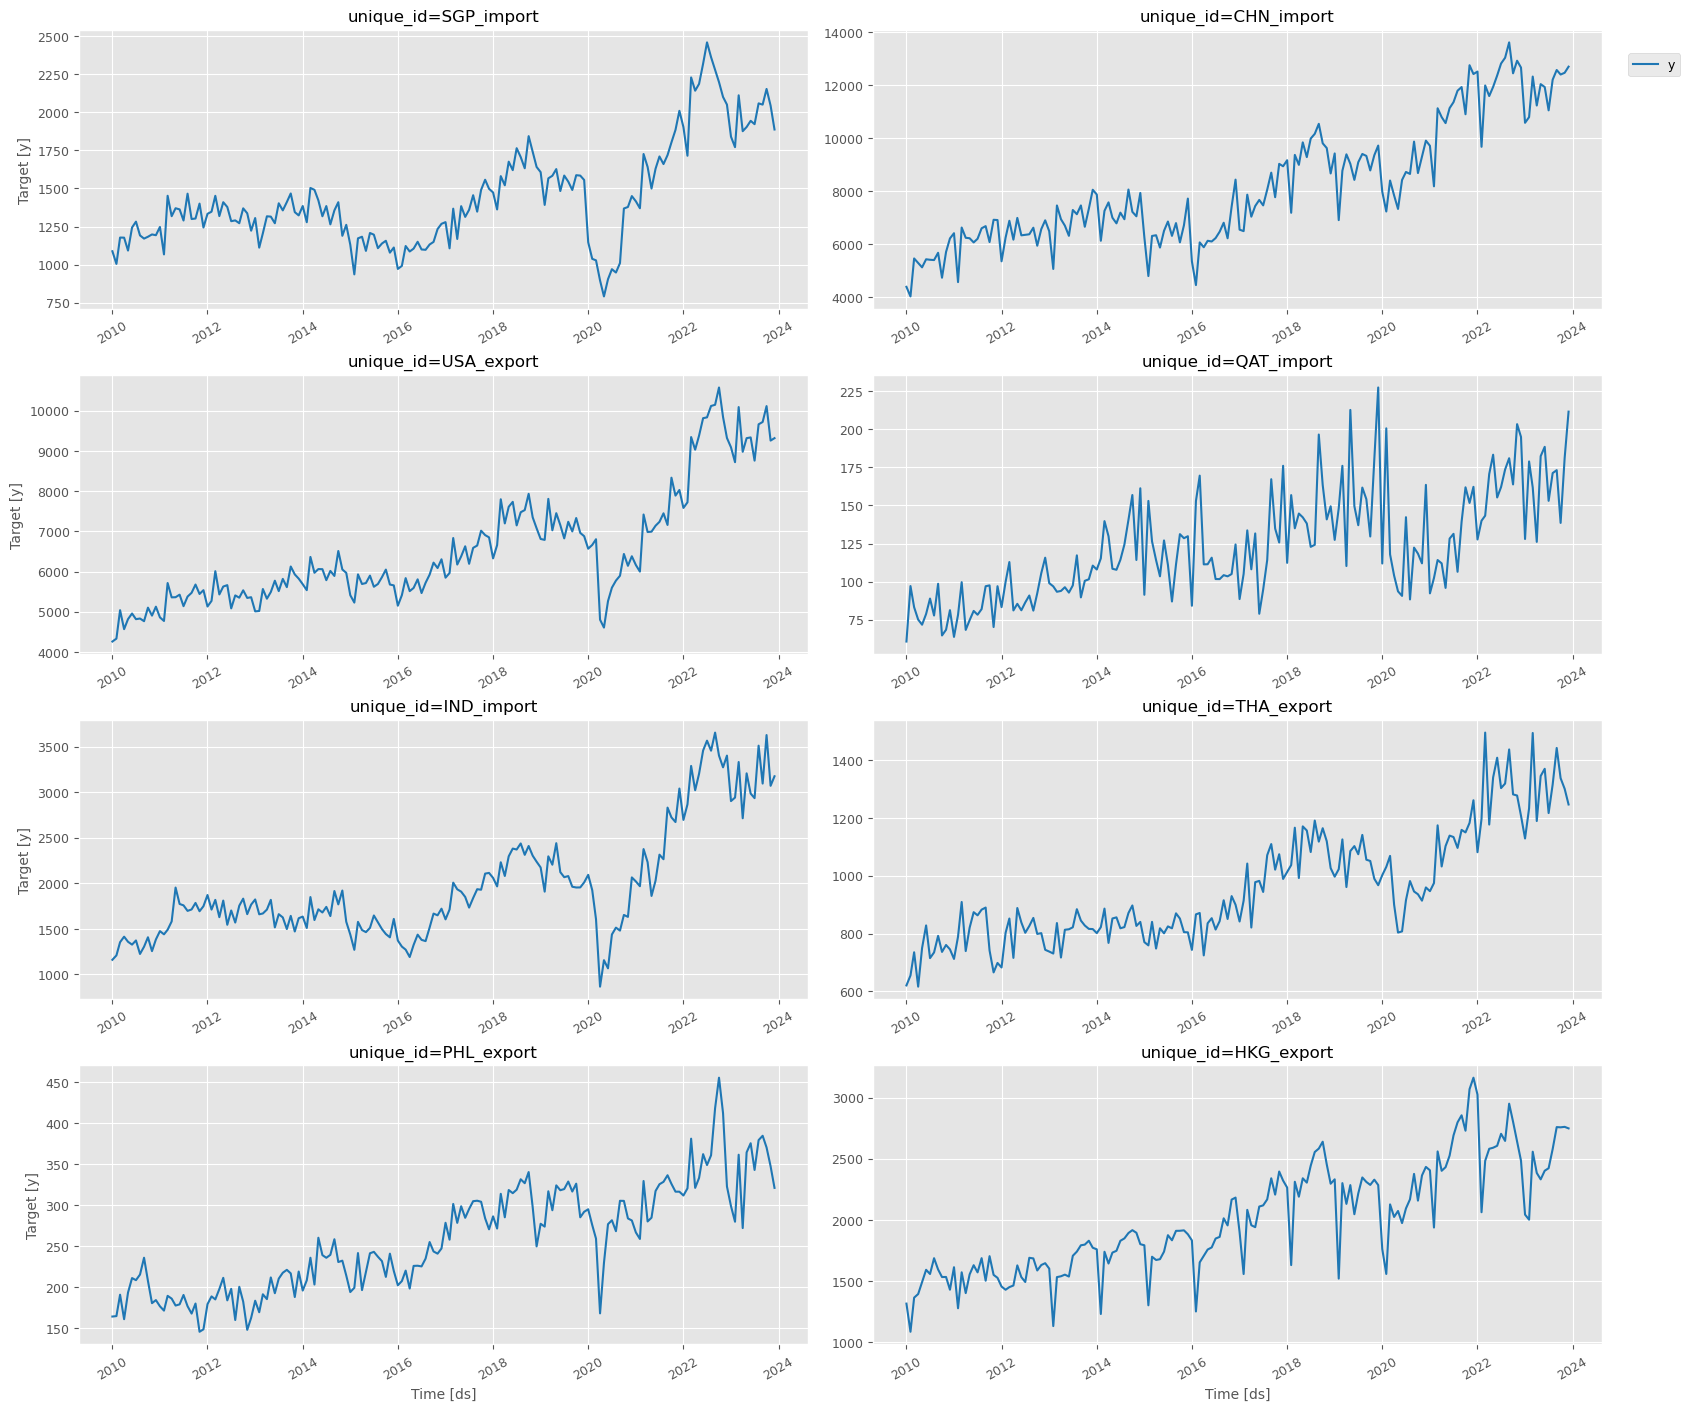

In [5]:
DAT_TRAIN = pd.read_csv(f'{DIR}/TRAIN.csv', parse_dates=['ds'],index_col=0)
DAT_TEST = pd.read_csv(f'{DIR}/TEST.csv', parse_dates=['ds'],index_col=0)


from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
# plot_series(DAT_TRAIN,
#             DAT_TEST)
plot_series(DAT_TRAIN)


In [6]:
print(DAT_TRAIN.columns)

Index(['ds', 'unique_id', 'y'], dtype='object')


### Model A: Baseline DeepAR (Vanilla model)
Here we test the vanilla Deep Learning models such as DeepAR, NBeats, and TSMixer. These models are available under NIXTLA's Neuralforecast package.

We investigate whether a global ML model can forecast the import and export activity. In particular, we assess whether a global model, with cross-learning, can out-perform local models trained for specific dataset.

Model A is a vanilla model of DeepAR using the import and export volumes as inputs (without introducing any engineered features)

In [7]:
from neuralforecast import NeuralForecast
from neuralforecast.models import DeepAR, TFT #TFT, NBEATS, TimeGPT
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.losses.pytorch import MQLoss  # Import a compatible loss
import torch
torch.set_float32_matmul_precision('medium')


h = 6

models = [DeepAR(h=h,
                 input_size=2*h, #when predicting h, lookback 2*h
                 max_steps=1000,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64, 
                 ),
 TFT(
        h=h,
        input_size=2*h,
        hidden_size=128,
        n_head=4,
        loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
        max_steps=400,  # keep small while testing
    )
                 
          ]

nf = NeuralForecast(models=models, freq='M')
# nf.fit(df=DAT_TRAIN)

Seed set to 1
Seed set to 1


In [8]:
n_windows = 3  # Number of cross-validation folds

cv_df = nf.cross_validation(
    df=DAT_TRAIN,
    n_windows=n_windows,
    # h=h,
    step_size=h, # This ensures non-overlapping test sets
    refit=False # Set to True to retrain the model on each new window, but this is much slower
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
from neuralforecast.losses.numpy import mase, mae

# Calculate Mean Absolute Error (MAE) for each model
# Note: For DeepAR's DistributionLoss, MAE is calculated from the mean of the distribution
deepar_mae = mae(cv_df['y'].values, cv_df['DeepAR'].values)
tft_mae = mae(cv_df['y'].values, cv_df['TFT'].values)

print(f"DeepAR Average MAE: {deepar_mae:.4f}")
print(f"TFT Average MAE: {tft_mae:.4f}")

# To compare probabilistic forecasts, use a metric that accounts for prediction intervals
# NeuralForecast's utils can provide these metrics
# However, for a simple comparison, MAE on the point forecast (mean or median) is a good start.
# If you used MQLoss, you would compare the total loss for each model.
# Total MQL for TFT: (20%_quantile_loss + 50%_quantile_loss + 80%_quantile_loss) / 3

print("\n--- Summary ---")
if deepar_mae < tft_mae:
    print("🏆 DeepAR has a lower MAE and performs better on this dataset.")
else:
    print("🏆 TFT has a lower MAE and performs better on this dataset.")

DeepAR Average MAE: 204.6800
TFT Average MAE: 186.3706

--- Summary ---
🏆 TFT has a lower MAE and performs better on this dataset.


In [10]:
h = len(DAT_TEST.ds.unique()) + 1

models = [TFT(
        h=h,
        input_size=2*h,
        hidden_size=128,
        n_head=4,
        loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
        max_steps=400,  # keep small while testing
    )
                 
          ]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=DAT_TRAIN)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.


In [11]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

df_f = nf.predict() # Forecast!
df_f["ds"] = pd.to_datetime(df_f["ds"]).dt.to_period("M").dt.to_timestamp()
df_f = pd.merge(DAT_TEST, df_f, on=['ds', 'unique_id']) # append ground truth "y"

def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape


df_eval = evaluate(df_f, 
                   metrics=[mae, rmse, mape, partial(mase, seasonality=12),
                                   partial(rmsse, seasonality=12)],
                   train_df=DAT_TRAIN) # mase uses snaive as scaler
# df_eval.pivot(index='unique_id', columns='metric', values='DeepAR')
df_eval.pivot(index='unique_id', columns='metric', values=['TFT'])

/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

TFT                                
metric           mae    mape   mase      rmse  rmsse
unique_id                                           
AUS_export    86.572   5.472  0.479   103.699  0.456
AUS_import   167.501  11.695  1.481   184.283  1.289
CHN_export  1668.959  10.572  1.439  2012.297  1.302
CHN_import   630.542   5.645  0.634   969.535  0.770
HKG_export   245.629   9.644  1.343   342.278  1.354
HKG_import   314.310  11.143  1.523   384.155  1.434
IDN_export   177.788  13.532  1.379   201.390  1.155
IDN_import    78.185   6.675  0.641   104.840  0.676
IND_export   144.372   6.591  0.748   178.381  0.665
IND_import   333.712   9.361  0.906   403.618  0.812
JPN_export   262.830   8.398  1.011   349.857  1.085
JPN_import   225.108   6.218  0.531   265.722  0.522
KOR_export   137.717   4.343  0.530   179.853  0.540
KOR_import   215.762   7.088  0.689   247.120  0.617
MMR_export    16.022  21.110  1.489    18.167  1.264
MMR_import    18.163  32.871  1.375    20.626  1.255
MYS_export   316.124  19.081  2.361   351.226  1.951
MYS_import   305.429  20.482  2.613   332.963  2.066
NZL_export    21.338  10.271  1.047    25.305  0.965
NZL_import    29.061  12.225  1.185    36.575  1.141
PAK_export    10.409   7.121  0.853    12.609  0.730
PAK_import    23.383   8.329  0.593    28.268  0.498
PHL_export    23.748   6.515  0.817    29.250  0.751
PHL_import    77.633  12.248  1.267    91.361  1.090
QAT_export    54.848  11.527  0.497    64.111  0.465
QAT_import    24.596  15.471  1.001    29.683  0.913
SGP_export   359.989  14.619  1.451   381.572  1.154
SGP_import   438.080  19.564  1.825   464.916  1.473
THA_export   168.027  11.206  1.910   193.976  1.654
THA_import   241.362  17.730  2.009   254.077  1.668
TWN_export   199.120   8.419  1.296   250.603  1.207
TWN_import   391.244  19.760  2.331   428.310  1.920
USA_export   841.948   8.327  1.181   944.478  0.966
USA_import     0.065   6.511  0.000     0.078  0.000
VNM_export   133.816   7.400  1.003   169.455  0.987
VNM_import   143.160   8.288  1.147   170.764  1.070

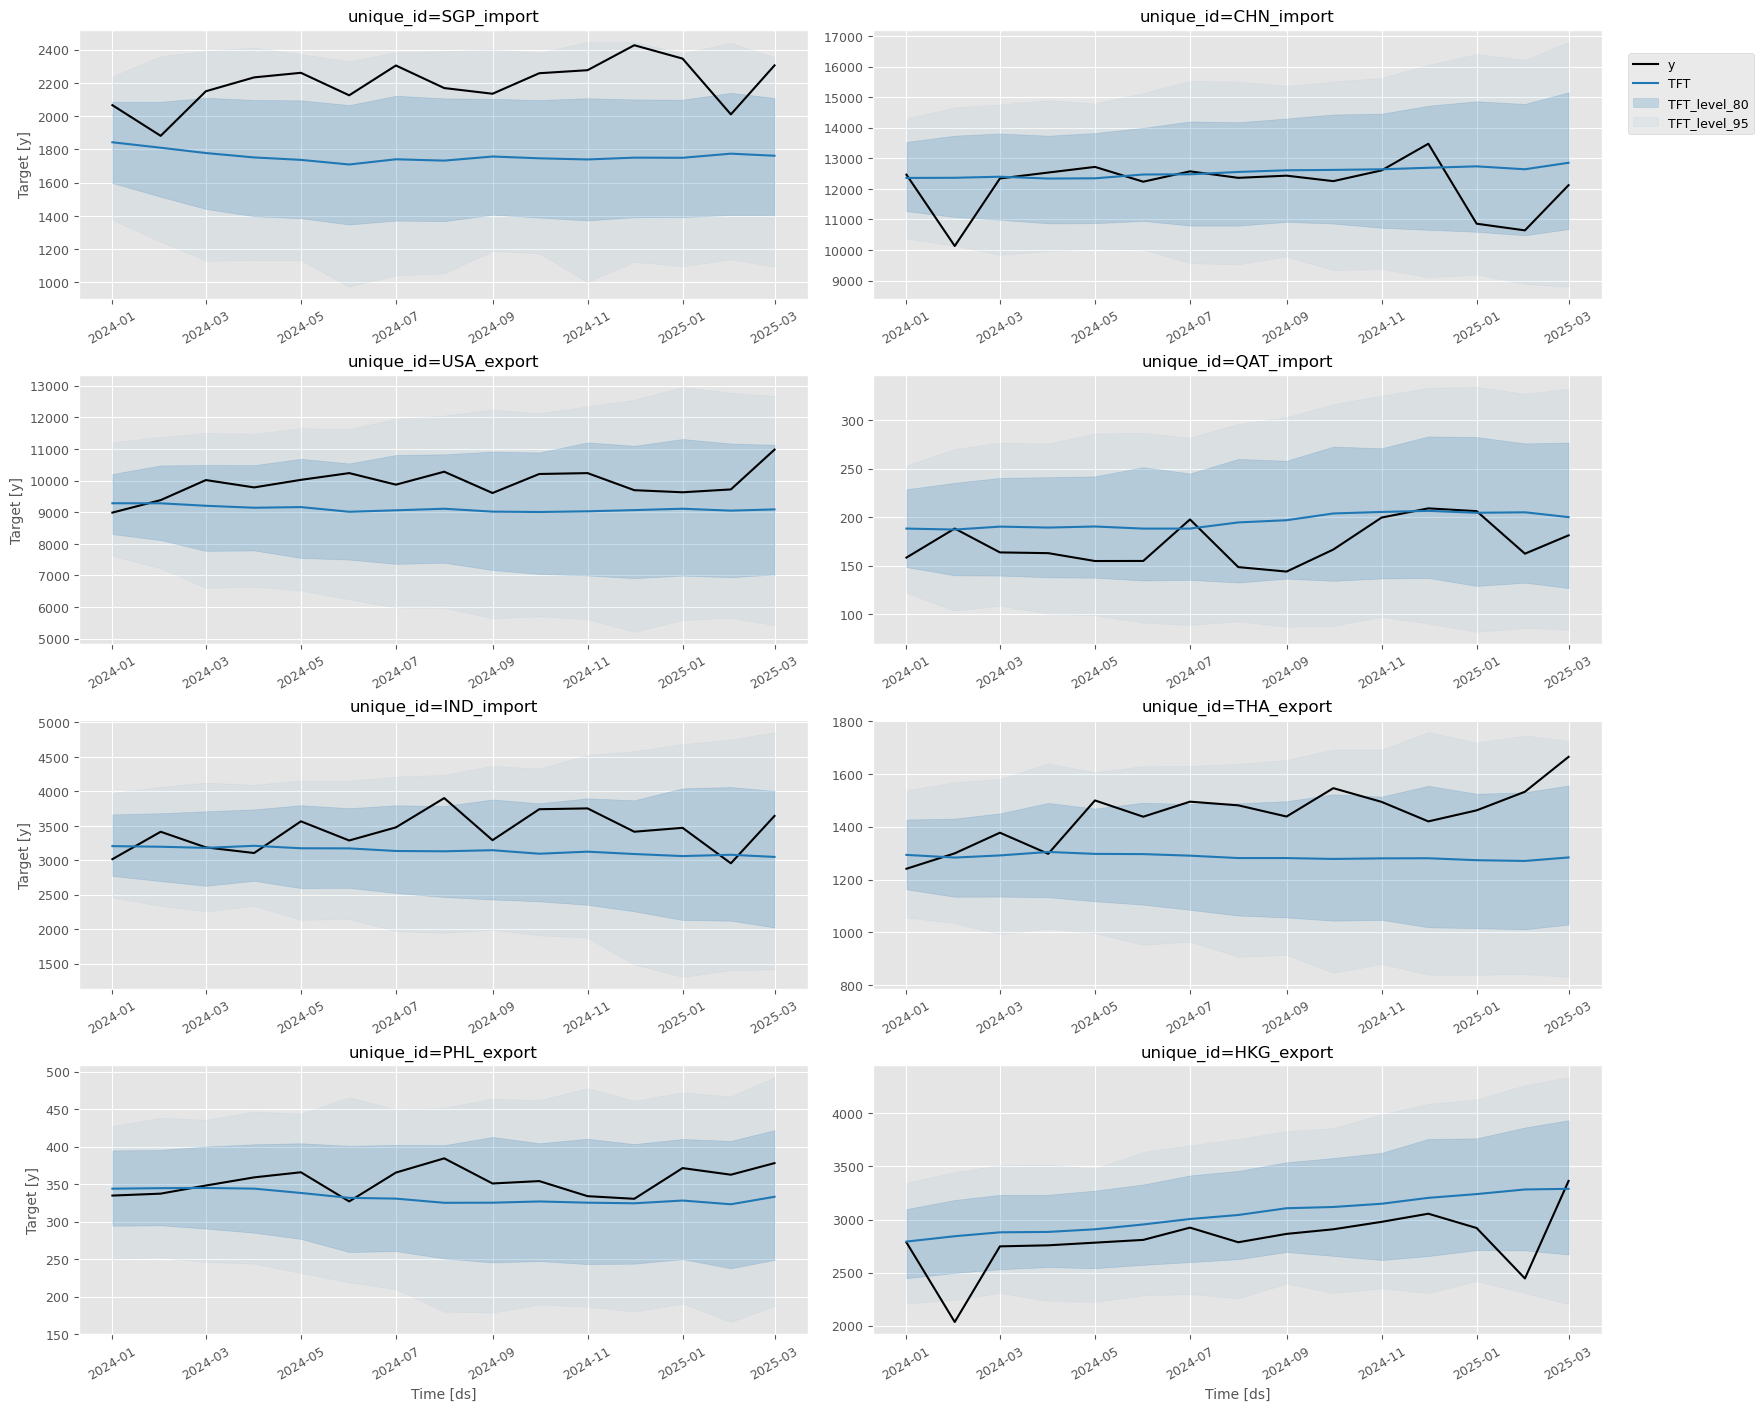

In [12]:
from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plot_series(DAT_TEST, df_f.drop(['TFT-median', 'y'], axis=1), level=[80, 95])

### Model B: DeepAR with feature engineering
Now we add some context to the forecast by adding static covariates. This would capture country-specific and time-specific trends.



In [13]:
### (b) features DeepAR
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

features = [
    partial(fourier, season_length = 3, k=2),
    partial(time_features, features = ['quarter'])
]

df_train, df_futr = pipeline(
    DAT_TRAIN,
    features = features,
    freq = 'MS',
    h=h
)

df_train




,ds,unique_id,y,sin1_3,sin2_3,cos1_3,cos2_3,quarter
0,2010-01-01,AUS_export,618.538,8.660e-01,-8.660e-01,-0.5,-0.5,1
1,2010-02-01,AUS_export,613.971,-8.660e-01,8.660e-01,-0.5,-0.5,1
2,2010-03-01,AUS_export,699.770,1.748e-07,3.497e-07,1.0,1.0,1
3,2010-04-01,AUS_export,769.386,8.660e-01,-8.660e-01,-0.5,-0.5,2
4,2010-05-01,AUS_export,829.484,-8.660e-01,8.660e-01,-0.5,-0.5,2
...,...,...,...,...,...,...,...,...
6043,2023-08-01,VNM_import,1606.879,-8.660e-01,8.660e-01,-0.5,-0.5,3
6044,2023-09-01,VNM_import,1619.624,3.418e-06,6.835e-06,1.0,1.0,3
6045,2023-10-01,VNM_import,1621.277,8.660e-01,-8.660e-01,-0.5,-0.5,4
6046,2023-11-01,VNM_import,1619.630,-8.660e-01,8.660e-01,-0.5,-0.5,4


In [14]:
h = 6

models = [DeepAR(h=h,
                 input_size=2*h, #when predicting h, lookback 2*h
                 max_steps=1000,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64, 
                 ),
 TFT(
        h=h,
        input_size=2*h,
        hidden_size=128,
        n_head=4,
        loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
        max_steps=400,  # keep small while testing
    )
                 
          ]

nf = NeuralForecast(models=models, freq='M')

Seed set to 1
Seed set to 1


In [15]:
n_windows = 3  # Number of cross-validation folds

cv_df = nf.cross_validation(
    df=df_train,
    n_windows=n_windows,
    # h=h,
    step_size=h, # This ensures non-overlapping test sets
    refit=False # Set to True to retrain the model on each new window, but this is much slower
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
cv_df.head()

,unique_id,ds,cutoff,DeepAR,DeepAR-median,DeepAR-lo-95,DeepAR-lo-80,DeepAR-hi-80,DeepAR-hi-95,TFT,TFT-median,TFT-lo-95,TFT-lo-80,TFT-hi-80,TFT-hi-95,y
0,AUS_export,2022-07-01,2022-06-01,1889.476,1889.418,1477.205,1641.691,2152.479,2325.763,1916.493,1910.077,1374.718,1613.339,2233.307,2473.854,1811.283
1,AUS_export,2022-08-01,2022-06-01,1902.790,1907.465,1333.101,1612.365,2176.992,2327.206,1924.372,1931.157,1328.307,1558.687,2274.363,2525.418,1960.359
2,AUS_export,2022-09-01,2022-06-01,1909.467,1919.229,1355.501,1589.117,2233.870,2379.827,1902.588,1911.816,1273.301,1502.495,2273.753,2489.410,2038.088
3,AUS_export,2022-10-01,2022-06-01,1912.452,1881.602,1265.519,1531.518,2229.107,2418.199,1933.453,1915.992,1275.898,1561.482,2334.819,2635.142,1950.821
4,AUS_export,2022-11-01,2022-06-01,1913.606,1946.612,1399.463,1607.251,2329.684,2572.351,1903.934,1908.151,1245.159,1510.211,2301.164,2565.857,1900.337


In [17]:
from neuralforecast.losses.numpy import mase, mae

# Calculate Mean Absolute Error (MAE) for each model
# Note: For DeepAR's DistributionLoss, MAE is calculated from the mean of the distribution
deepar_mae = mae(cv_df['y'].values, cv_df['DeepAR'].values)
tft_mae = mae(cv_df['y'].values, cv_df['TFT'].values)

print(f"DeepAR Average MAE: {deepar_mae:.4f}")
print(f"TFT Average MAE: {tft_mae:.4f}")

# To compare probabilistic forecasts, use a metric that accounts for prediction intervals
# NeuralForecast's utils can provide these metrics
# However, for a simple comparison, MAE on the point forecast (mean or median) is a good start.
# If you used MQLoss, you would compare the total loss for each model.
# Total MQL for TFT: (20%_quantile_loss + 50%_quantile_loss + 80%_quantile_loss) / 3

print("\n--- Summary ---")
if deepar_mae < tft_mae:
    print("🏆 DeepAR has a lower MAE and performs better on this dataset.")
else:
    print("🏆 TFT has a lower MAE and performs better on this dataset.")

DeepAR Average MAE: 204.6800
TFT Average MAE: 186.3706

--- Summary ---
🏆 TFT has a lower MAE and performs better on this dataset.


### Try Import - Export Pairs by Country

In [19]:
DAT['unique_id'].unique()

array(['AUS_export', 'CHN_export', 'HKG_export', 'IND_export',
       'IDN_export', 'JPN_export', 'MYS_export', 'MMR_export',
       'NZL_export', 'PAK_export', 'PHL_export', 'QAT_export',
       'SGP_export', 'KOR_export', 'TWN_export', 'THA_export',
       'USA_export', 'VNM_export', 'USA_import', 'AUS_import',
       'CHN_import', 'HKG_import', 'IND_import', 'IDN_import',
       'JPN_import', 'MYS_import', 'MMR_import', 'NZL_import',
       'PAK_import', 'PHL_import', 'QAT_import', 'SGP_import',
       'KOR_import', 'TWN_import', 'THA_import', 'VNM_import'],
      dtype=object)

In [27]:
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

def evaluate_pair(pair_list):
    DAT_TEST_pair = DAT_TEST[DAT_TEST['unique_id'].isin(pair_list)]
    DAT_TRAIN_pair = DAT_TRAIN[DAT_TRAIN['unique_id'].isin(pair_list)]

    h = len(DAT_TEST_pair.ds.unique()) + 1

    models = [TFT(
            h=h,
            input_size=2*h,
            hidden_size=128,
            n_head=4,
            loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
            max_steps=200,  # keep small while testing
        )
                    
            ]

    nf = NeuralForecast(models=models, freq='M')
    nf.fit(df=DAT_TRAIN_pair)
    df_f = nf.predict() # Forecast!
    df_f["ds"] = pd.to_datetime(df_f["ds"]).dt.to_period("M").dt.to_timestamp()
    df_f = pd.merge(DAT_TEST_pair, df_f, on=['ds', 'unique_id']) # append ground truth "y"
    def mape(df, models, id_col="unique_id", target_col="y"):
        df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
        df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
        return df_mape

    df_eval = evaluate(df_f, 
                    metrics=[mae, rmse, mape, partial(mase, seasonality=12),
                                    partial(rmsse, seasonality=12)],
                    train_df=DAT_TRAIN_pair) # mase uses snaive as scaler
    return df_eval.pivot(index='unique_id', columns='metric', values=['TFT'])

In [28]:
importIDs = DAT_Import['unique_id'].unique()
exportIDs = DAT_Export['unique_id'].unique()

ph_export = []
for imp_id in importIDs:
    if imp_id != 'PHL_import':
        result = evaluate_pair(['PHL_export', imp_id])
        result = result.loc[['PHL_export']]
        print(result)
        ph_export.append({
            'pair' : f'{imp_id}-PHL_export',
            'mae' : result.loc['PHL_export', ('TFT', 'mae')],
            'mape' : result.loc['PHL_export', ('TFT', 'mape')],
            'rmse' : result.loc['PHL_export', ('TFT', 'rmse')],
            'rmsse' : result.loc['PHL_export', ('TFT', 'rmsse')],
        })
        # print(ph_export)

        

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_export  17.895  5.016  0.615  20.334  0.522


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

              TFT                             
metric        mae   mape   mase    rmse  rmsse
unique_id                                     
PHL_export  30.15  8.662  1.037  38.478  0.988


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                            
metric         mae   mape   mase   rmse  rmsse
unique_id                                     
PHL_export  28.172  8.115  0.969  36.57  0.939


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_export  18.539  5.166  0.637  21.268  0.546


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                              
metric         mae    mape   mase    rmse  rmsse
unique_id                                       
PHL_export  43.176  11.984  1.484  47.018  1.207


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_export  24.467  7.028  0.841  29.952  0.769


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                           
metric         mae   mape mase    rmse  rmsse
unique_id                                    
PHL_export  17.445  4.856  0.6  22.025  0.566


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

              TFT                             
metric        mae   mape   mase    rmse  rmsse
unique_id                                     
PHL_export  31.64  8.806  1.088  38.781  0.996


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_export  33.132  9.423  1.139  38.133  0.979


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                            
metric         mae  mape   mase    rmse  rmsse
unique_id                                     
PHL_export  20.963  5.84  0.721  24.017  0.617


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                           
metric         mae   mape   mase  rmse  rmsse
unique_id                                    
PHL_export  27.699  7.735  0.952  30.9  0.793


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                            
metric         mae   mape   mase   rmse  rmsse
unique_id                                     
PHL_export  35.898  9.932  1.234  41.54  1.067


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                            
metric         mae   mape   mase    rmse rmsse
unique_id                                     
PHL_export  41.336  11.43  1.421  48.292  1.24


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_export  13.979  4.043  0.481  17.717  0.455


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

              TFT                             
metric        mae   mape   mase    rmse  rmsse
unique_id                                     
PHL_export  15.57  4.465  0.535  18.788  0.482


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                              
metric         mae    mape   mase    rmse  rmsse
unique_id                                       
PHL_export  77.232  21.679  2.655  78.926  2.027


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_export  22.634  6.326  0.778  26.931  0.692


In [31]:
df_ph_export = pd.DataFrame.from_records(ph_export).sort_values('mae')
df_ph_export

,pair,mae,mape,rmse,rmsse
13,KOR_import-PHL_export,13.979,4.043,17.717,0.455
14,TWN_import-PHL_export,15.570,4.465,18.788,0.482
6,JPN_import-PHL_export,17.445,4.856,22.025,0.566
0,USA_import-PHL_export,17.895,5.016,20.334,0.522
3,HKG_import-PHL_export,18.539,5.166,21.268,0.546
9,NZL_import-PHL_export,20.963,5.840,24.017,0.617
16,VNM_import-PHL_export,22.634,6.326,26.931,0.692
5,IDN_import-PHL_export,24.467,7.028,29.952,0.769
10,PAK_import-PHL_export,27.699,7.735,30.900,0.793
2,CHN_import-PHL_export,28.172,8.115,36.570,0.939


In [35]:
ph_import = []
for imp_id in exportIDs:
    if imp_id != 'PHL_export':
        result = evaluate_pair(['PHL_import', imp_id])
        result = result.loc[['PHL_import']]
        print(result)
        ph_import.append({
            'pair' : f'{imp_id}-PHL_import',
            'mae' : result.loc['PHL_import', ('TFT', 'mae')],
            'mape' : result.loc['PHL_import', ('TFT', 'mape')],
            'rmse' : result.loc['PHL_import', ('TFT', 'rmse')],
            'rmsse' : result.loc['PHL_import', ('TFT', 'rmsse')],
        })
        # print(ph_export)


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                               
metric         mae    mape   mase     rmse  rmsse
unique_id                                        
PHL_import  88.695  14.098  1.448  100.452  1.199


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                               
metric         mae    mape   mase     rmse  rmsse
unique_id                                        
PHL_import  93.943  15.245  1.533  103.976  1.241


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

              TFT                         
metric        mae    mape mase  rmse rmsse
unique_id                                 
PHL_import  79.66  12.564  1.3  94.7  1.13


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                               
metric         mae    mape   mase     rmse  rmsse
unique_id                                        
PHL_import  90.793  14.759  1.482  100.751  1.202


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

                TFT                              
metric          mae    mape   mase    rmse  rmsse
unique_id                                        
PHL_import  158.861  25.593  2.593  168.21  2.008


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape  mase     rmse  rmsse
unique_id                                      
PHL_import  96.205  15.47  1.57  109.329  1.305


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                              
metric         mae    mape   mase    rmse  rmsse
unique_id                                       
PHL_import  64.644  10.292  1.055  79.767  0.952


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae    mape   mase   rmse  rmsse
unique_id                                      
PHL_import  81.611  12.909  1.332  95.86  1.144


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                               
metric         mae    mape   mase     rmse  rmsse
unique_id                                        
PHL_import  86.018  13.622  1.404  100.153  1.195


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                               
metric         mae    mape   mase     rmse  rmsse
unique_id                                        
PHL_import  91.104  14.527  1.487  101.919  1.216


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                               
metric         mae    mape   mase     rmse  rmsse
unique_id                                        
PHL_import  92.628  14.671  1.512  106.526  1.271


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_import  36.907  6.337  0.602  50.225  0.599


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                            
metric         mae   mape   mase    rmse rmsse
unique_id                                     
PHL_import  40.758  6.794  0.665  50.313   0.6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

               TFT                             
metric         mae    mape  mase    rmse  rmsse
unique_id                                      
PHL_import  69.233  11.036  1.13  82.302  0.982


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

                TFT                               
metric          mae    mape   mase     rmse  rmsse
unique_id                                         
PHL_import  103.639  16.503  1.691  117.677  1.404


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

              TFT                               
metric        mae    mape   mase     rmse  rmsse
unique_id                                       
PHL_import  98.79  15.992  1.612  111.038  1.325


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

               TFT                             
metric         mae   mape   mase    rmse  rmsse
unique_id                                      
PHL_import  39.552  6.446  0.646  47.163  0.563


In [34]:
ph_import

[]

In [36]:
df_ph_import = pd.DataFrame.from_records(ph_import).sort_values('mae')
df_ph_import

,pair,mae,mape,rmse,rmsse
11,SGP_export-PHL_import,36.907,6.337,50.225,0.599
16,VNM_export-PHL_import,39.552,6.446,47.163,0.563
12,KOR_export-PHL_import,40.758,6.794,50.313,0.600
6,MYS_export-PHL_import,64.644,10.292,79.767,0.952
13,TWN_export-PHL_import,69.233,11.036,82.302,0.982
2,HKG_export-PHL_import,79.660,12.564,94.700,1.130
7,MMR_export-PHL_import,81.611,12.909,95.860,1.144
8,NZL_export-PHL_import,86.018,13.622,100.153,1.195
0,AUS_export-PHL_import,88.695,14.098,100.452,1.199
3,IND_export-PHL_import,90.793,14.759,100.751,1.202


In [37]:
df_ph_export

,pair,mae,mape,rmse,rmsse
13,KOR_import-PHL_export,13.979,4.043,17.717,0.455
14,TWN_import-PHL_export,15.570,4.465,18.788,0.482
6,JPN_import-PHL_export,17.445,4.856,22.025,0.566
0,USA_import-PHL_export,17.895,5.016,20.334,0.522
3,HKG_import-PHL_export,18.539,5.166,21.268,0.546
9,NZL_import-PHL_export,20.963,5.840,24.017,0.617
16,VNM_import-PHL_export,22.634,6.326,26.931,0.692
5,IDN_import-PHL_export,24.467,7.028,29.952,0.769
10,PAK_import-PHL_export,27.699,7.735,30.900,0.793
2,CHN_import-PHL_export,28.172,8.115,36.570,0.939


In [45]:
ph_only = []
result = evaluate_pair(['PHL_export'])
result = result.loc[['PHL_export']]
# print(result)
ph_only.append({
    'pair' : f'PHL_export',
    'mae' : result.loc['PHL_export', ('TFT', 'mae')],
    'mape' : result.loc['PHL_export', ('TFT', 'mape')],
    'rmse' : result.loc['PHL_export', ('TFT', 'rmse')],
    'rmsse' : result.loc['PHL_export', ('TFT', 'rmsse')],
})

        

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [46]:
result = evaluate_pair(['PHL_import'])
result = result.loc[['PHL_import']]
ph_only.append({
    'pair' : f'PHL_import',
    'mae' : result.loc['PHL_import', ('TFT', 'mae')],
    'mape' : result.loc['PHL_import', ('TFT', 'mape')],
    'rmse' : result.loc['PHL_import', ('TFT', 'rmse')],
    'rmsse' : result.loc['PHL_import', ('TFT', 'rmsse')],
})
# print(ph_export)
df_ph_only = pd.DataFrame.from_records(ph_only).sort_values('mae')
df_ph_only
        

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,pair,mae,mape,rmse,rmsse
0,PHL_export,22.673,6.429,27.030,0.694
1,PHL_import,123.400,19.975,132.248,1.578


### Try imports for all countries vs PH exports

In [49]:
ph_all_counties = []
id_list = exportIDs.tolist()
id_list.append('PHL_import')
result = evaluate_pair(id_list)
result = result.loc[['PHL_import']]
ph_all_counties.append({
    'pair' : f'PHL_import',
    'mae' : result.loc['PHL_import', ('TFT', 'mae')],
    'mape' : result.loc['PHL_import', ('TFT', 'mape')],
    'rmse' : result.loc['PHL_import', ('TFT', 'rmse')],
    'rmsse' : result.loc['PHL_import', ('TFT', 'rmsse')],
})

id_list = importIDs.tolist()
id_list.append('PHL_export')
result = evaluate_pair(id_list)
result = result.loc[['PHL_export']]
ph_all_counties.append({
    'pair' : f'PHL_export',
    'mae' : result.loc['PHL_export', ('TFT', 'mae')],
    'mape' : result.loc['PHL_export', ('TFT', 'mape')],
    'rmse' : result.loc['PHL_export', ('TFT', 'rmse')],
    'rmsse' : result.loc['PHL_export', ('TFT', 'rmsse')],
})
# print(ph_export)
df_ph_all_counties = pd.DataFrame.from_records(ph_all_counties).sort_values('mae')
df_ph_all_counties
        

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,pair,mae,mape,rmse,rmsse
0,PHL_import,40.779,6.686,48.090,0.574
1,PHL_export,47.015,13.006,54.577,1.401
